In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', 200)

import pandas as pd
import numpy as np
import re

# Distance

In [ ]:
modules = pd.read_csv('./data/modules_2.csv', sep=',')
filtered_DB = pd.read_csv('./data/filtered_DB_2.csv', sep=',')

In [4]:
# Group by 'cluster_id' and aggregate 'protein_id' into a list
clusters = filtered_DB.groupby('cluster_id')['protein_id'].apply(list).reset_index()

clusters['size'] = clusters['protein_id'].apply(len)
clusters

,cluster_id,protein_id,size
0,sample_1067_contig_10080_protocluster_1_downstream_5,"[sample_1067_contig_10080_protocluster_1_downstream_5, sample_5650_contig_114_protocluster_1_downstream_114, sample_14219_contig_1094_protocluster_1_upstream_11]",3
1,sample_1067_contig_1014_protocluster_1_downstream_4,"[sample_1067_contig_1014_protocluster_1_downstream_4, sample_14228_contig_4382_protocluster_1_upstream_2, sample_2401_contig_213_protocluster_1_downstream_58]",3
2,sample_1067_contig_1014_protocluster_1_downstream_5,"[sample_1067_contig_1014_protocluster_1_downstream_5, sample_2401_contig_213_protocluster_1_downstream_57, sample_14228_contig_4382_protocluster_1_upstream_3]",3
3,sample_1067_contig_1016_protocluster_1_upstream_37,"[sample_1067_contig_1016_protocluster_1_upstream_37, sample_5054_contig_119_protocluster_1_downstream_32, sample_5056_contig_637_protocluster_1_upstream_49]",3
4,sample_1067_contig_1021_protocluster_1_upstream_18,"[sample_1067_contig_1021_protocluster_1_upstream_18, sample_1073_contig_267_protocluster_1_downstream_44, sample_9335_contig_1078_protocluster_1_downstream_14, sample_1813_contig_480_protocluster_...",6
...,...,...,...
42703,sample_TMT438_contig_1857_protocluster_1_upstream_3,"[sample_TMT438_contig_1857_protocluster_1_upstream_3, sample_17789_contig_7757_protocluster_1_upstream_3, sample_14210_contig_17715_protocluster_1_downstream_5, sample_14210_contig_17715_protoclus...",32
42704,sample_TMT438_contig_254_protocluster_1_upstream_8,"[sample_TMT438_contig_254_protocluster_1_upstream_8, sample_14210_contig_1817_protocluster_1_downstream_8, sample_17512_contig_164_protocluster_1_upstream_7]",3
42705,sample_TMT438_contig_301_protocluster_2_downstream_11,"[sample_TMT438_contig_301_protocluster_2_downstream_11, sample_5526_contig_1847_protocluster_1_downstream_17, sample_759_contig_16028_protocluster_1_downstream_11]",3
42706,sample_TMT438_contig_440_protocluster_1_upstream_2,"[sample_TMT438_contig_440_protocluster_1_upstream_2, sample_8288_contig_1438_protocluster_1_downstream_15, sample_5650_contig_2117_protocluster_1_upstream_5, sample_16240_contig_3993_protocluster_...",6


In [ ]:
module_protein_ids = {}

for module in modules['module_id'].unique():
    pcs_raw = modules.loc[module - 1, 'cluster_ids']
    pcs_cleaned = pcs_raw.replace("'", "").replace(" ", "").replace("[", "").replace("]", "")
    pcs_list = pcs_cleaned.split(",")

    # Собираем списки protein_id для каждого pcs
    cluster_proteins = []
    for pcs_name in pcs_list:
        proteins = clusters[clusters['cluster_id'] == pcs_name]['protein_id'].explode().tolist()
        cluster_proteins.append(proteins)

    module_protein_ids[module] = cluster_proteins

modules['mmseq_protein_ids'] = modules['module_id'].map(module_protein_ids)
modules.head(1)


,module_id,module_size,cluster_ids,cluster_inds,cluster_sizes,mmseq_protein_ids
0,1,2,"['sample_1067_contig_10080_protocluster_1_downstream_5', 'sample_8289_contig_377_protocluster_1_downstream_28']","[0, 36907]","[3, 19]","[[sample_1067_contig_10080_protocluster_1_downstream_5, sample_5650_contig_114_protocluster_1_downstream_114, sample_14219_contig_1094_protocluster_1_upstream_11], [sample_8289_contig_377_protoclu..."


In [ ]:
modules['number_mmseq_proteins'] = modules['mmseq_protein_ids'].apply(len)

modules['immuneisland_count'] = modules['mmseq_protein_ids'].apply(
    lambda x: sum('immuneisland' in str(protein) for protein in x)
)

modules['immuneisland_fraction'] = modules['immuneisland_count'] / modules['number_mmseq_proteins']

modules.head(1)

,module_id,module_size,cluster_ids,cluster_inds,cluster_sizes,mmseq_protein_ids,number_mmseq_proteins,immuneisland_count,immuneisland_fraction
0,1,2,"['sample_1067_contig_10080_protocluster_1_downstream_5', 'sample_8289_contig_377_protocluster_1_downstream_28']","[0, 36907]","[3, 19]","[[sample_1067_contig_10080_protocluster_1_downstream_5, sample_5650_contig_114_protocluster_1_downstream_114, sample_14219_contig_1094_protocluster_1_upstream_11], [sample_8289_contig_377_protoclu...",2,0,0.0


In [ ]:
# Extracts the prefix from protein_id by removing the trailing number after the last underscore
def extract_prefix(protein_id):
    match = re.match(r'(.+)_\d+$', protein_id)
    return match.group(1) if match else None

# Extracts the number at the end of the protein_id after the last underscore
def extract_number(protein_id):
    match = re.search(r'_(\d+)$', protein_id)
    return int(match.group(1)) if match else None

# Computes the average absolute distance between all pairs of numbers from two lists
def compute_distance(numbers1, numbers2):
    total_distance = 0
    num_pairs = 0
    for n1 in numbers1:
        for n2 in numbers2:
            total_distance += abs(n1 - n2)
            num_pairs += 1
    return (total_distance / num_pairs) - 1 if num_pairs > 0 else None

# List to store output rows containing distance calculations between cluster protein pairs
cluster_pair_rows = []

# Iterate over each module in the dataframe
for idx, row in modules_df.iterrows():
    module_id = row['module_id']
    
    # Convert cluster_ids string to list by removing brackets and quotes
    pcs_list = row['cluster_ids'].replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(",")
    
    # List of protein IDs grouped by cluster
    protein_lists = row['mmseq_protein_ids']

    prefix_dict = {}

    # Extract prefix and number for each protein and group by prefix
    for cluster_number, cluster in enumerate(protein_lists):
        for protein in cluster:
            prefix = extract_prefix(protein)
            number = extract_number(protein)
            if prefix and number is not None:
                prefix_dict.setdefault(prefix, []).append((cluster_number, number))

    # Group numbers by cluster for each prefix
    for prefix, proteins in prefix_dict.items():
        cluster_dict = {}
        for cluster_number, number in proteins:
            cluster_dict.setdefault(cluster_number, []).append(number)

        # Compare every pair of clusters for the current prefix and calculate average distance
        for cluster_id_1, numbers_1 in cluster_dict.items():
            for cluster_id_2, numbers_2 in cluster_dict.items():
                if cluster_id_1 < cluster_id_2:  # avoid duplicate pairs and self-comparison
                    distance = compute_distance(numbers_1, numbers_2)
                    if distance is not None:
                        cluster_pair_rows.append({
                            'module_id': module_id,
                            'cluster_ids': ', '.join(pcs_list),
                            'mmseq_protein_ids': protein_lists,
                            'prefix': prefix,
                            'numbers_1': numbers_1,
                            'numbers_2': numbers_2,
                            'distance': distance
                        })

# Create a dataframe from the results
pairwise_df = pd.DataFrame(cluster_pair_rows)
pairwise_df.head()


,module_id,cluster_ids,mmseq_protein_ids,prefix,numbers_1,numbers_2,distance
0,1,"sample_1067_contig_10080_protocluster_1_downstream_5, sample_8289_contig_377_protocluster_1_downstream_28","[[sample_1067_contig_10080_protocluster_1_downstream_5, sample_5650_contig_114_protocluster_1_downstream_114, sample_14219_contig_1094_protocluster_1_upstream_11], [sample_8289_contig_377_protoclu...",sample_5650_contig_114_protocluster_1_downstream,[114],[120],5.0
1,1,"sample_1067_contig_10080_protocluster_1_downstream_5, sample_8289_contig_377_protocluster_1_downstream_28","[[sample_1067_contig_10080_protocluster_1_downstream_5, sample_5650_contig_114_protocluster_1_downstream_114, sample_14219_contig_1094_protocluster_1_upstream_11], [sample_8289_contig_377_protoclu...",sample_14219_contig_1094_protocluster_1_upstream,[11],[5],5.0
2,2,"sample_1067_contig_1014_protocluster_1_downstream_4, sample_1067_contig_1014_protocluster_1_downstream_5, sample_2401_contig_213_protocluster_1_downstream_56","[[sample_1067_contig_1014_protocluster_1_downstream_4, sample_14228_contig_4382_protocluster_1_upstream_2, sample_2401_contig_213_protocluster_1_downstream_58], [sample_1067_contig_1014_protoclust...",sample_1067_contig_1014_protocluster_1_downstream,[4],[5],0.0
3,2,"sample_1067_contig_1014_protocluster_1_downstream_4, sample_1067_contig_1014_protocluster_1_downstream_5, sample_2401_contig_213_protocluster_1_downstream_56","[[sample_1067_contig_1014_protocluster_1_downstream_4, sample_14228_contig_4382_protocluster_1_upstream_2, sample_2401_contig_213_protocluster_1_downstream_58], [sample_1067_contig_1014_protoclust...",sample_1067_contig_1014_protocluster_1_downstream,[4],[6],1.0
4,2,"sample_1067_contig_1014_protocluster_1_downstream_4, sample_1067_contig_1014_protocluster_1_downstream_5, sample_2401_contig_213_protocluster_1_downstream_56","[[sample_1067_contig_1014_protocluster_1_downstream_4, sample_14228_contig_4382_protocluster_1_upstream_2, sample_2401_contig_213_protocluster_1_downstream_58], [sample_1067_contig_1014_protoclust...",sample_1067_contig_1014_protocluster_1_downstream,[5],[6],0.0


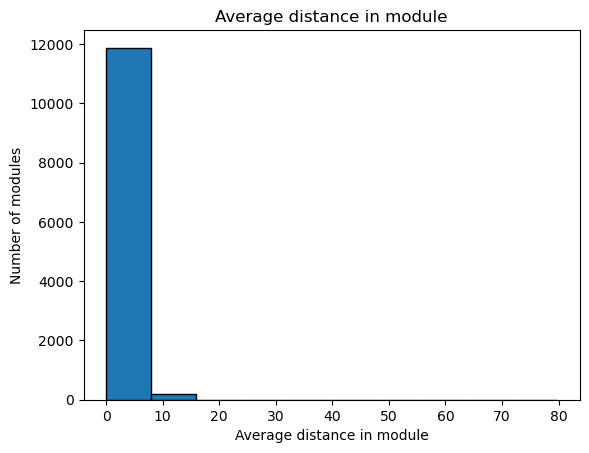

In [ ]:
# Calculate the average distance per module
avg_distance_per_module = pairwise_df.groupby('module_id')['distance'].mean().reset_index()

# Plot histogram of average distances
plt.hist(avg_distance_per_module['distance'],edgecolor='black')

plt.title('Average distance in module')
plt.xlabel('Average distance in module')
plt.ylabel('Number of modules')

plt.show()